# K Means Clustering on UBS Technology Incidents

Stephen Anstis, Matt Riley, Richard Walker Jan 2019  

### Problem Statement: 
UBS collects data on technology incidents, and these are associated with Applications.
We sometimes lack sufficient understanding of underlying incident patterns across applications. With appropriate levels of analysis and evaluation, UBS could ultimately take steps to try and reduce recurrence, and thus lowering operational risk. 

### Approach:
Here we have a K-means clustering approach to try and identify patterns within incident and application characteristics, and provide some interpretation of these.  
As part of this exercise we performed data cleanup, excluding several well-known applications/groups that produced outlying data.
Identifiers within the data have been anonymised.


### Step 1. Import Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


### Step 2.  Get data
Here we import a CSV export of ServiceNow incident count data, per application, from 2018. 
This data has been joined with ISAC INKA (Asset ID) counts per application, as an indicator of application complexity.

In [2]:
mydata = pd.read_csv('INC INKA Counts Cleaned.csv')
mydata.describe()

,INKA Count,Incident Count,Incident Mins
count,504.000000,624.000000,624.000000
mean,53.148810,2.548077,28514.924306
std,220.364184,4.461096,59889.690052
min,1.000000,1.000000,10.000000
25%,5.000000,1.000000,2163.537500
50%,12.000000,1.000000,8700.050000
75%,24.250000,2.000000,28889.912500
max,3046.000000,78.000000,681737.783300


### Step 3. Transform the data for Python

Here we are converting the numeric data types from CSV string import

In [3]:
mydata[['Incident Count']].apply(pd.to_numeric)
mydata[['INKA Count']].apply(pd.to_numeric)
mydata[['Incident Mins']].apply(pd.to_numeric)

mydata.dtypes




Orgmapping1        object
Orgmapping2        object
Orgmapping3        object
Orgmapping4        object
Service Id         object
INKA Count        float64
Incident Count      int64
Incident Mins     float64
dtype: object

In [4]:
mydata.describe()

,INKA Count,Incident Count,Incident Mins
count,504.000000,624.000000,624.000000
mean,53.148810,2.548077,28514.924306
std,220.364184,4.461096,59889.690052
min,1.000000,1.000000,10.000000
25%,5.000000,1.000000,2163.537500
50%,12.000000,1.000000,8700.050000
75%,24.250000,2.000000,28889.912500
max,3046.000000,78.000000,681737.783300


In [5]:
mydata.head()

,Orgmapping1,Orgmapping2,Orgmapping3,Orgmapping4,Service Id,INKA Count,Incident Count,Incident Mins
0,Division 1,Division 1,Division 1,Division 1,App683308,NaN,1,3116.233333
1,Division 1,Division 1,Division 1,Division 1,App583552,9.0,5,6298.183333
2,Division 1,Division 1,Division 1,Division 1,App77267,4.0,5,8340.116667
3,Division 1,Division 1,Division 1,Division 1,App962978,3.0,1,1910.766667
4,Division 1,Division 1,Division 1,Division 1,App208986,11.0,3,215799.050000


### Step 4. Visualise the original data

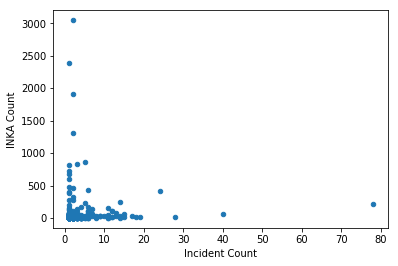

In [6]:
mydata.plot.scatter(x='Incident Count',y='INKA Count')

### Step 5.  Remove Division 5 data, remove nulls, and visualise again
The original data is already "clustered" around 0 on both axes. We have a long tail spread of individual data points which we know about, but we don't know about the central cluster. Let's remove one category of data responsible for these large outlying data points.  Also need to remove any N/A or null values from either measure,  as we cannot analyse these.

In [7]:
mydata = mydata.drop(mydata[mydata['Orgmapping1']=='Division 5'].index)

In [8]:
mydata = mydata.dropna(subset=['Incident Count', 'INKA Count'])

In [9]:
mydata.describe()

,INKA Count,Incident Count,Incident Mins
count,444.000000,444.000000,444.000000
mean,24.986486,2.871622,28856.346059
std,54.958961,5.179331,60747.307324
min,1.000000,1.000000,10.000000
25%,5.000000,1.000000,2021.575000
50%,11.000000,1.000000,8460.683334
75%,21.000000,3.000000,26864.650000
max,601.000000,78.000000,681737.783300


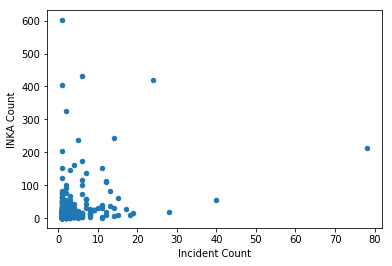

In [10]:
mydata.plot.scatter(x='Incident Count',y='INKA Count')



### Step 6. Remove outliers to analyse core data
We still have quite a few outliers that can be identified and removed as we really want to work out what's going on within the cluster of values < 20 incidents. Doing this gives a more distributed scatter that we can run K-Means clustering on.

In [11]:
mydata = mydata.drop(mydata[mydata['Incident Count']>20].index)

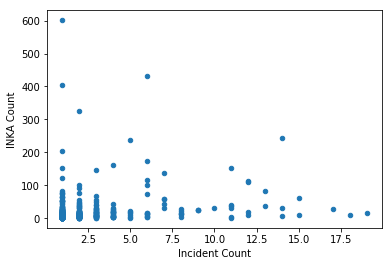

In [12]:
mydata.plot.scatter(x='Incident Count',y='INKA Count')

In [13]:
mydata.describe()

,INKA Count,Incident Count,Incident Mins
count,440.000000,440.000000,440.000000
mean,23.602273,2.511364,27820.429811
std,51.067453,2.913304,58987.908662
min,1.000000,1.000000,10.000000
25%,5.000000,1.000000,2003.766667
50%,11.000000,1.000000,8342.533333
75%,20.000000,3.000000,26005.779170
max,601.000000,19.000000,681737.783300


### Step 7. Apply K-means clustering and visualise the clusters
Now we can run our clustering algorithm and evaluate the clusters visually.


In [14]:
data = []
for index,row in mydata.iterrows():
    incidents = row['Incident Count']
    INKAs = row['INKA Count']
    data.append([float(incidents),float(INKAs)])
    

model = KMeans(n_clusters = 4)
model.fit(scale(data))

mydata['cluster'] = model.labels_.astype(float)


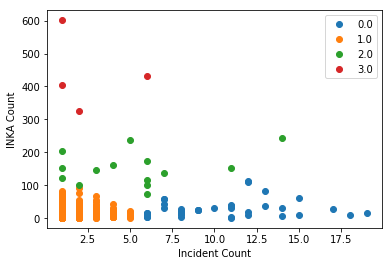

In [15]:
groups = mydata.groupby('cluster')

groups.head()
# Plot the clusters
fix,ax = plt.subplots()
for name, group in groups:
    ax.plot(group['Incident Count'],group['INKA Count'],marker='o',linestyle='',label=name)
    
plt.xlabel('Incident Count')
plt.ylabel('INKA Count')
ax.legend()

### Step 8. Provide data interpretation 
We have a nice set of four clusters each corresponding with a scenario:

1. Simpler application with fewer incidents
2. Simpler application with many incidents
3. Complex application with fewer incidents
4. Complex application with many incidents


### Step 9. Export relevant clusters 
We may be interested in cluster 1.0, which is the" Simpler application with many incidents".  We can export these for further action:

In [16]:

mydata[mydata['cluster']==1.0]


,Orgmapping1,Orgmapping2,Orgmapping3,Orgmapping4,Service Id,INKA Count,Incident Count,Incident Mins,cluster
1,Division 1,Division 1,Division 1,Division 1,App583552,9.0,5,6298.183333,1.0
2,Division 1,Division 1,Division 1,Division 1,App77267,4.0,5,8340.116667,1.0
3,Division 1,Division 1,Division 1,Division 1,App962978,3.0,1,1910.766667,1.0
4,Division 1,Division 1,Division 1,Division 1,App208986,11.0,3,215799.050000,1.0
5,Division 1,Division 1,Division 1,Division 1,App210564,6.0,1,227.650000,1.0
7,Division 1,Division 1,Division 1,Division 1,App702974,4.0,1,11869.166670,1.0
8,Division 1,Division 1,Division 1,Division 1,App399864,4.0,1,4880.166667,1.0
10,Division 1,Division 1,Division 1,Division 1,App410014,29.0,4,101835.783300,1.0
11,Division 1,Division 1,Division 1,Division 1,App131290,4.0,1,192.483333,1.0
12,Division 1,Division 1,Division 1,Division 1,App952690,18.0,3,8466.450000,1.0


### Step 10. Use Elbow test to validate number of clusters
Here we can validate that four clusters is about the right quantity for our analysis.

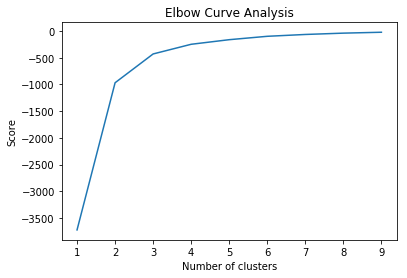

In [19]:
x = mydata[['INKA Count']]
y = mydata[['Incident Count']]
num_clusters = [1,2,3,4,5,6,7,8,9]

kmeans = [KMeans(n_clusters=i) for i in num_clusters ]
score = [kmeans[i-1].fit(y).score(y) for i in num_clusters ]

plt.plot(num_clusters,score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Elbow Curve Analysis')
plt.show()
